# 🧪 Custom Annoy (Approximate Nearest Neighbors Oh Yeah) Classification

In this notebook, we implement Annoy **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `KNeighborsClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [25]:
import heapq
from math import ceil
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [26]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [27]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall and F1-score — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average="weighted")
        recall = recall_score(y, y_pred, average="weighted")
        f1 = f1_score(y, y_pred, average="weighted")

        evaluations.loc[:, name] = [accuracy, precision, recall, f1]

    return evaluations.astype(float)

In [ ]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [29]:
def plot_classification_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize boundaries of traine models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [30]:
# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_classes=4,
    n_clusters_per_class=1,
    n_redundant=0,
    class_sep=1.8,
    random_state=42,
)

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [ ]:
class AnnoyNode:
    """Node used in the Annoy tree.

    Attributes:
        points (NDArray[np.float64]): Data points stored in the node.
        labels (NDArray[np.float64]): Corresponding labels for the data points.
        split_point (NDArray[np.float64] | None): Reference point for the
            hyperplane split.
        normal (NDArray[np.float64] | None): Normal vector defining the
            split hyperplane.
        left (AnnoyNode | None): Left subtree (positive side of the hyperplane).
        right (AnnoyNode | None): Right subtree (negative side of the hyperplane).
        leaf (bool): Whether this node is a leaf (i.e., contains <= leaf_size points).
    """

    def __init__(
        self, points: NDArray[np.float64], labels: NDArray[np.float64]
    ) -> None:
        """Initialize an AnnoyNode with given data points and their labels.

        Args:
            points (NDArray[np.float64]): Data points stored in this node.
            labels (NDArray[np.float64]): Labels corresponding to the data points.
        """
        self.points = points
        self.labels = labels

        self.leaf: bool = False
        self.split_point: NDArray[np.float64] | None = None
        self.normal: NDArray[np.float64] | None = None
        self.left: "AnnoyNode" | None = None
        self.right: "AnnoyNode" | None = None


class AnnoyIndex:
    """Approximate Nearest Neighbors (ANN) structure using random projection trees.

    Attributes:
        k (int): Dimensionality of the feature space.
        root (AnnoyNode): Root node of the built tree.
        leaf_size (int): Maximum number of points in a leaf node.
        p (float): Order of the Minkowski distance used for nearest neighbor search.
        rng (Generator): Random number generator used for hyperplane sampling.
    """

    def __init__(
        self,
        points: NDArray[np.float64],
        labels: NDArray[np.float64],
        leaf_size: int = 5,
        p: float = 2.0,
        seed: int = 42,
    ) -> None:
        """Construct the Annoy tree from the provided points and labels.

        Args:
            points (NDArray[np.float64]): Array of data points, shape
                (n_samples, n_features).
            labels (NDArray[np.float64]): Corresponding labels for the points.
            leaf_size (int): Maximum number of points per leaf. Defaults to 5.
            p (float): Minkowski distance order. Defaults to 2 (Euclidean).
            seed (int): Random seed for reproducibility. Defaults to 42.
        """
        self.k: int = points.shape[1] if points.size else 0
        self.leaf_size = leaf_size
        self.p = p

        self.rng: RandomGenerator = np.random.default_rng(seed)
        self.root: AnnoyNode = self.build(points, labels)

    def _minkowski_metric(
        self, a: NDArray[np.float64], b: NDArray[np.float64], p: float = 2.0
    ) -> float:
        """Calculate Minkowski distance of order p between two points.

        Args:
            a (NDArray[np.float64]): First point.
            b (NDArray[np.float64]): Second point.
            p (float): Order of the Minkowski distance.

        Returns:
            float: Minkowski distance between points a and b.
        """
        return np.sum(np.abs(a - b) ** p) ** (1 / p)

    def build(
        self, points: NDArray[np.float64], labels: NDArray[np.float64]
    ) -> AnnoyNode | None:
        """Recursively build the Annoy tree from the given points and labels.

        Args:
            points (NDArray[np.float64]): Data points to build the tree with.
            labels (NDArray[np.float64]): Corresponding labels.

        Returns:
            AnnoyNode | None: The root of the constructed subtree, or None if empty.
        """
        if points.shape[0] == 0:
            return None

        node = AnnoyNode(points, labels)

        if points.shape[0] <= self.leaf_size:
            node.leaf = True
            return node

        i1, i2 = self.rng.choice(points.shape[0], size=2, replace=False)
        p1, p2 = points[i1], points[i2]
        node.normal = p2 - p1
        node.split_point = p1

        proj = np.dot(points - p1, node.normal)

        node.left = self.build(points[proj > 0], labels[proj > 0])
        node.right = self.build(points[proj <= 0], labels[proj <= 0])

        return node

    def _search_k_nearest_neighbors(
        self,
        point: NDArray[np.float64],
        k: int,
        node: AnnoyNode,
        best_heap: list[tuple[float, float]],
    ) -> list[tuple[float, AnnoyNode]]:
        """Recursively search for k nearest neighbors of a query point.

        Args:
            point (NDArray[np.float64]): Query point.
            k (int): Number of nearest neighbors to retrieve.
            node (AnnoyNode): Current node in the tree.
            best_heap (list[tuple[float, float]]): Max-heap storing (-distance, label)
                for the current best neighbors.

        Returns:
            list[tuple[float, float]]: Heap of k nearest neighbors as
                (-distance, label).
        """
        if node is None:
            return best_heap

        if node.leaf:
            for node_point, node_label in zip(node.points, node.labels, strict=False):
                dist = self._minkowski_metric(point, node_point, self.p)

                if len(best_heap) < k:
                    heapq.heappush(best_heap, (-dist, node_label))
                    continue

                if dist < -best_heap[0][0]:
                    heapq.heappushpop(best_heap, (-dist, node_label))

            return best_heap

        side: float = 0.0
        if node.normal is not None and node.split_point is not None:
            side = np.dot(point - node.split_point, node.normal)

        if side > 0:
            next_branch, other_branch = node.left, node.right
        else:
            next_branch, other_branch = node.right, node.left

        self._search_k_nearest_neighbors(point, k, next_branch, best_heap)

        if len(best_heap) < k or abs(side) < -best_heap[0][0]:
            self._search_k_nearest_neighbors(point, k, other_branch, best_heap)

        return best_heap

    def search_k_nearest_neighbors(
        self,
        point: NDArray[np.float64],
        k: int,
    ) -> list[tuple[float, AnnoyNode]]:
        """Find the k nearest neighbors of the query point using the Annoy tree.

        Args:
            point (NDArray[np.float64]): Query point to search for.
            k (int): Number of neighbors to return.

        Returns:
            tuple[NDArray[np.float64], NDArray[np.float64]]:
                Distances and labels of the k nearest neighbors, both as arrays.
        """
        best_heap = self._search_k_nearest_neighbors(point, k, self.root, [])
        neighbors = sorted(best_heap, key=lambda x: -x[0])

        neighbor_distances, neighbor_labels = zip(*neighbors, strict=False)
        neighbor_distances = -np.array(neighbor_distances)
        neighbor_labels = np.array(neighbor_labels)

        return neighbor_distances, neighbor_labels

In [ ]:
class MyKNeighborsClassifier:
    """K-Nearest Neighbors Classifier with Gaussian kernel weighting & annoy.

    Predicts the class label for each input sample based on the weighted vote
    of its k nearest neighbors in the training data, using Minkowski distance
    and a Gaussian kernel to assign weights to neighbors.

    Attributes:
        k_neighbors (int): Number of nearest neighbors to consider.
        p (float): Power parameter for the Minkowski distance.
        h (float): Bandwidth parameter for the Gaussian kernel.
        X_train (NDArray[np.float64] | None): Training features.
        y_train (NDArray[np.float64] | None): Training labels.
        annoy (AnnoyIndex | None): Annoy index structure.
    """

    def __init__(
        self,
        k_neighbors: int = 3,
        p: float = 2.0,
        h: float = 1.0,
        annoy_leaf_size: int = 5,
    ) -> None:
        """Initialize the KNN classifier.

        Args:
            k_neighbors (int): Number of neighbors to consider. Defaults to 3.
            p (float): Order of the Minkowski distance metric. Defaults to 2.0.
            h (float): Bandwidth parameter for the Gaussian kernel. Defaults to 1.0.
            annoy_leaf_size (int): Maximum number of points per leaf for Annoy.
                Defaults to 5.
        """
        self.k_neighbors = k_neighbors
        self.p = p
        self.h = h
        self.annoy_leaf_size = annoy_leaf_size

        self.X_train: NDArray[np.float64] | None = None
        self.y_train: NDArray[np.int64] | None = None
        self.annoy: AnnoyIndex | None = None

    def _gaussian_kernel(self, t: NDArray[np.float64]) -> NDArray[np.float64]:
        """Gaussian (normal) kernel function.

        Args:
            t (NDArray[np.float64]): Input values.

        Returns:
            NDArray[np.float64]: Kernel-weighted values.
        """
        return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Store training data for future predictions.

        Args:
            X (NDArray[np.float64]): Training feature matrix of shape
                (n_samples, n_features).
            y (NDArray[np.int64]): Target values of shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y
        self.annoy = AnnoyIndex(X, y, p=self.p, leaf_size=self.annoy_leaf_size)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        y_pred = []
        for x_new in X:
            neighbor_distances, neighbor_labels = self.annoy.search_k_nearest_neighbors(
                x_new, self.k_neighbors
            )

            weights = self._gaussian_kernel(neighbor_distances / self.h)

            class_weights = {}
            for label, weight in zip(neighbor_labels, weights, strict=False):
                class_weights[label] = class_weights.get(label, 0) + weight

            predicted_label = max(class_weights, key=class_weights.get)
            y_pred.append(predicted_label)

        return np.array(y_pred, dtype=np.int64)

### 🏋️‍♂️ Model Training

In [ ]:
# Scikit-learn kNN classifier model
sklearn_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
sklearn_model.fit(X_train, y_train)

# My kNN classifier with annoy model
my_model = MyKNeighborsClassifier(k_neighbors=5, p=5, h=5.8, annoy_leaf_size=20)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [35]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my annoy": my_model.predict(X_test),
}

models = {
    "scikit-learn": sklearn_model,
    "my annoy": my_model,
}

In [36]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my annoy
Accuracy,0.965000,0.975000
Precision,0.965312,0.975046
Recall,0.965000,0.975000
F1-score,0.964648,0.974925


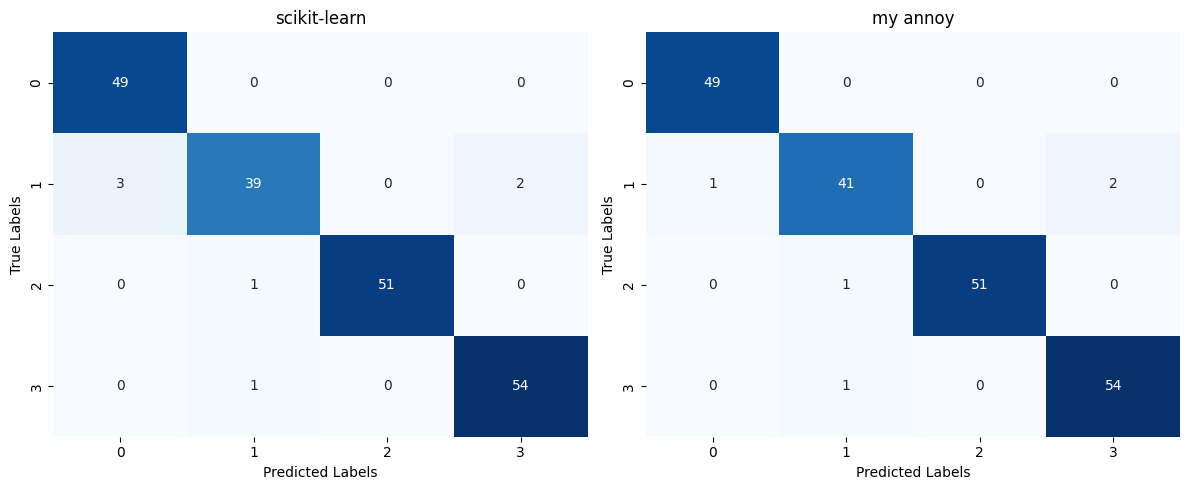

In [37]:
plot_confusion_matrices(predictions, y_test)

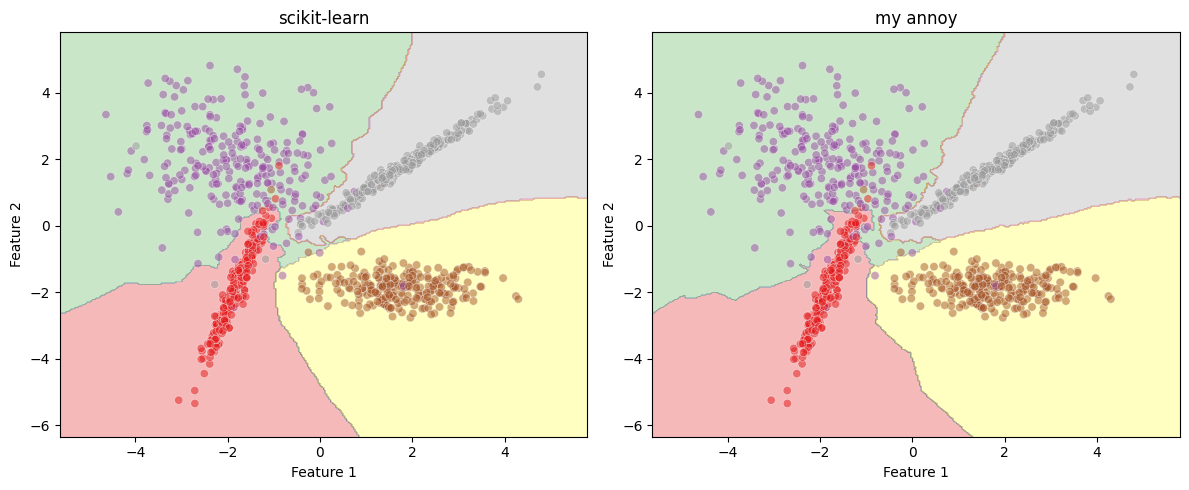

In [38]:
plot_classification_boundaries(models, X, y)